In [1]:

# Set up notebook
%pprint
%matplotlib inline
import sys
import os.path as osp, os as os

executable_path = sys.executable
scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts'); assert osp.exists(scripts_folder)
py_folder = osp.abspath(osp.join(os.pardir, 'py')); assert osp.exists(py_folder), "Create the py folder"
ffmpeg_folder = r'C:\ffmpeg\bin'; assert osp.exists(ffmpeg_folder)
shared_folder = osp.abspath(osp.join(os.pardir, 'share')); assert osp.exists(shared_folder)

if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)

from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join(os.pardir, 'data')),
    saves_folder_path=osp.abspath(osp.join(os.pardir, 'saves'))
)
nu.delete_ipynb_checkpoint_folders()

# Import needed libraries
import re

Pretty printing has been turned OFF


In [2]:

def get_combined_image(img, caption, font, font_size=48, verbose=False):

    # Load the original image
    original_image = Image.open(img).convert("RGBA")
    img_size = original_image.size
    if verbose:
        print(img_size)
    
    # Create a TextClip with a specific background color
    txt_clip = TextClip(font, caption, font_size=font_size, color='white', size=img_size, bg_color='black', vertical_align='bottom')
    
    # Create a new image with the text overlay
    txt_image = txt_clip.get_frame(0)  # Get the text frame as an image
    txt_image = Image.fromarray(txt_image)  # Convert to PIL Image
    
    # Convert txt_image to RGBA to match original_image
    txt_image = txt_image.convert("RGBA")
    if verbose:
        print(txt_image.size)
    
    # Create a transparent alpha channel for the text image
    pixel_data = txt_image.getdata()
    new_image_data = []

    # Get the max distance from black
    distances_set = set()
    unique_rgbs = set(pixel_data)
    for to_rgb_tuple in unique_rgbs:
        distances_set.add(nu.color_distance_from('black', to_rgb_tuple[:3]))
    assert min(distances_set) == 0.0
    max_distance = max(distances_set)
    
    # Loop through the data (RGBA values)
    for item in pixel_data:
        
        # Replace it with a relatively transparent RGBA value
        transparency_value = int(nu.color_distance_from('black', item[:3])*255/max_distance)
        assert 0 <= transparency_value <= 255
        new_image_data.append((item[0], item[1], item[2], transparency_value))
        
    txt_image.putdata(new_image_data)

    # Combine the original image with the text image
    combined_image = Image.alpha_composite(original_image, txt_image)
    if verbose:
        display(combined_image)
    
    return combined_image

In [3]:

import tempfile
def get_modified_image_paths(images, captions, font, font_size=48):
    modified_images = []
    
    # Create a temporary directory
    temp_dir = tempfile.mkdtemp()  # Create a temporary directory that won't be deleted automatically
    
    try:
        # Loop through the data (RGBA values)
        for img, caption in tqdm(zip(images, captions), total=min(len(images), len(captions)), desc='Create the Modified Images'):
            
            # Combine the original image with the text image
            combined_image = get_combined_image(img, caption, font, font_size=font_size, verbose=False)
            # display(combined_image)
            
            # Save the combined image to the temporary directory
            modified_image_path = osp.join(temp_dir, f"modified_{osp.basename(img)}")
            combined_image.save(modified_image_path, format="PNG")
            
            # Append the path of the modified image to the list
            modified_images.append(modified_image_path)
    
    except Exception as e:
        print(f"An error occurred: {e}")
    
    return modified_images, temp_dir  # Return both the modified image paths and the temp directory

In [4]:

import glob

pattern = osp.join('C:\\', '**', '*.otf')
if nu.pickle_exists('opentype_fonts'):
    opentype_fonts = nu.load_object('opentype_fonts')
else:
    opentype_fonts = [font for font in glob.glob(pattern, recursive=True) if '$Recycle.Bin' not in font]
    nu.store_objects(opentype_fonts=opentype_fonts)
images = [osp.join(nu.data_folder, 'png', f"image{i:02}.png") for i in range(13)]
all_captions = [
    "Here is a woman who is always tired,\nShe lives a life where too much is required.\nWith dreams on her shoulders, heavy as stone,\nIn the hustle and bustle, she often feels alone.\nDays filled with duties, from dawn until night,\nChasing her shadows, she fights the good fight.\nYet in her heart glimmers a flickering flame,\nA whisper of hope, calling out her name.\nShe yearns for a moment, a pause in the race,\nTo breathe in the stillness, to find her own space.\nFor within her resilience lies beauty untold,\nA spirit unbroken, a heart made of gold.",
    "Here is a woman who is always tired,",
    "She lives a life where too much is required.",
    "With dreams on her shoulders, heavy as stone,",
    "In the hustle and bustle, she often feels alone.",
    "Days filled with duties, from dawn until night,",
    "Chasing her shadows, she fights the good fight.",
    "Yet in her heart glimmers a flickering flame,",
    "A whisper of hope, calling out her name.",
    "She yearns for a moment, a pause in the race,",
    "To breathe in the stillness, to find her own space.",
    "For within her resilience lies beauty untold,",
    "A spirit unbroken, a heart made of gold.",
]
soundtracks = [osp.abspath(f) for f in glob.glob('../data/mp3/*.mp3')]
filename_regex = re.compile("[^A-Za-z0-9]+")

In [5]:

# Remove inappropriate sound tracks
bad_soundtracks = ['C:\\Users\\daveb\\OneDrive\\Documents\\GitHub\\notebooks\\data\\mp3\\Weightless by Marconi Union.mp3']
soundtracks = [i for i in soundtracks if i not in bad_soundtracks]

In [13]:

# Remove illegible fonts
bad_fonts = [
    r'C:\texlive\2022\texmf-dist\fonts\opentype\public\txfontsb\FreeSerifb-SmallCaps.otf',
    r'C:\texlive\2022\texmf-dist\fonts\opentype\public\cm-unicode\cmunorm.otf'
]
opentype_fonts = [i for i in opentype_fonts if i not in bad_fonts]

In [11]:

# Get the images and captions
images = [osp.join(nu.data_folder, 'png', 'incremental', f"image{i:02}.png") for i in range(1, 13)]
captions = all_captions[1:]

In [24]:

from moviepy import ImageClip, TextClip, concatenate_videoclips, AudioFileClip
import random
from PIL import Image
from tqdm import tqdm

# Create the file prefix
font = random.choice(opentype_fonts)
soundtrack = random.choice(soundtracks)
file_name_prefix = filename_regex.sub("_", osp.basename(soundtrack).split('.')[0]).strip('_') + '_' + filename_regex.sub("_", osp.basename(font).split('.')[0])
file_name = file_name_prefix + '.mp4'
video_path = osp.join(nu.saves_folder, 'mp4', file_name)
print(file_name_prefix)

A_Sky_Full_of_Stars_by_Coldplay_Instrumental_Version_AlegreyaSC_Regular


C:\texlive\2022\texmf-dist\fonts\opentype\huerta\alegreya\AlegreyaSC-Regular.otf


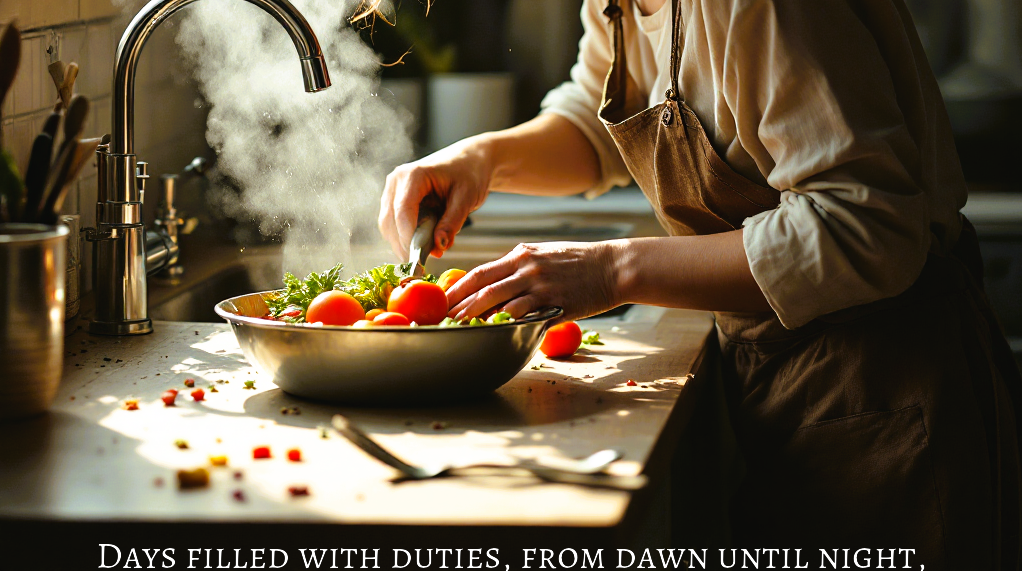

In [25]:

print(font)
assert len(images) == len(captions)
# random_index = random.randint(0, len(images)-1)
random_index = 4
display(get_combined_image(images[random_index], captions[random_index], font, font_size=38, verbose=False))

In [26]:

# Save the combined images to a temporary location
modified_images, temp_dir = get_modified_image_paths(images, captions, font, font_size=38)

Create the Modified Images: 100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.20s/it]


In [27]:

# Get the duration of the audio in seconds
audio = AudioFileClip(soundtrack)
audio_duration = audio.duration

# Calculate the number of clips
num_clips = len(modified_images)

# Calculate the duration for each ImageClip
clip_duration = audio_duration / num_clips

# Now convert the modified images into video clips
clips = []
for modified_img in tqdm(modified_images, total=num_clips, desc='Convert the Images'):
    
    # Create an image clip
    img_clip = ImageClip(modified_img, duration=clip_duration)  # Display each modified image for the calculated duration
    # display(Image.fromarray(img_clip.get_frame(0)))
    
    # Don't have to combine image and caption as a composite video clip now, just add it
    clips.append(img_clip)

# After you're done using the modified images, you can clean up the temporary directory
import shutil
shutil.rmtree(temp_dir)  # This will delete the temporary directory and all its contents

Convert the Images: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.72it/s]


In [28]:

# Concatenate all video clips
final_video = concatenate_videoclips(clips, method="compose")

# Add the soundtrack
final_video = final_video.with_audio(audio)
final_video.fps = 24

# Write the final movie to a file (MP4)
os.makedirs(name=osp.dirname(video_path), exist_ok=True)
# final_video.write_videofile(video_path, codec='libx264', fps=24) # Uses unsupported encoding settings
# final_video.write_videofile(video_path, codec='libx264', fps=24, pixel_format='rgb24') # Uses unsupported encoding settings
# final_video.write_videofile(video_path, codec='libx264', fps=24, pixel_format='rgba') # Uses unsupported encoding settings
# final_video.write_videofile(video_path, codec='mpeg4', fps=24)  # Encodes in mp4v format, which isn't supported
# final_video.write_videofile(video_path, codec='mpeg4', fps=24, pixel_format='rgb24')  # Encodes in mp4v format, which isn't supported
# final_video.write_videofile(video_path, codec='mpeg4', fps=24, pixel_format='rgba')  # Encodes in mp4v format, which isn't supported
final_video.write_videofile(video_path)  # , logger=proglog.TqdmProgressBarLogger(notebook=True)

MoviePy - Building video C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\saves\mp4\A_Sky_Full_of_Stars_by_Coldplay_Instrumental_Version_AlegreyaSC_Regular.mp4.
MoviePy - Writing audio in A_Sky_Full_of_Stars_by_Coldplay_Instrumental_Version_AlegreyaSC_RegularTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\saves\mp4\A_Sky_Full_of_Stars_by_Coldplay_Instrumental_Version_AlegreyaSC_Regular.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\saves\mp4\A_Sky_Full_of_Stars_by_Coldplay_Instrumental_Version_AlegreyaSC_Regular.mp4


In [8]:

!explorer.exe "{osp.dirname(video_path)}"


----

In [32]:

import moviepy
[f'moviepy.VideoClip.{fn}' for fn in dir(moviepy.VideoClip) if 'write' in fn.lower()]

['moviepy.VideoClip.write_gif', 'moviepy.VideoClip.write_images_sequence', 'moviepy.VideoClip.write_videofile']

In [33]:

moviepy.VideoClip.write_videofile?

Signature:
moviepy.VideoClip.write_videofile(
    self,
    filename,
    fps=None,
    codec=None,
    bitrate=None,
    audio=True,
    audio_fps=44100,
    preset='medium',
    audio_nbytes=4,
    audio_codec=None,
    audio_bitrate=None,
    audio_bufsize=2000,
    temp_audiofile=None,
    temp_audiofile_path='',
    remove_temp=True,
    write_logfile=False,
    threads=None,
    ffmpeg_params=None,
    logger='bar',
    pixel_format=None,
)
Docstring:
Write the clip to a videofile.

Parameters
----------

filename
  Name of the video file to write in, as a string or a path-like object.
  The extension must correspond to the "codec" used (see below),
  or simply be '.avi' (which will work with any codec).

fps
  Number of frames per second in the resulting video file. If None is
  provided, and the clip has an fps attribute, this fps will be used.

codec
  Codec to use for image encoding. Can be any codec supported
  by ffmpeg. If the filename is has extension '.mp4', '.ogv', '.we

In [38]:

ImageClip?

Init signature:
ImageClip(
    img,
    is_mask=False,
    transparent=True,
    fromalpha=False,
    duration=None,
)
Docstring:     
Class for non-moving VideoClips.

A video clip originating from a picture. This clip will simply
display the given picture at all times.

Examples
--------

>>> clip = ImageClip("myHouse.jpeg")
>>> clip = ImageClip( someArray ) # a Numpy array represent

Parameters
----------

img
  Any picture file (png, tiff, jpeg, etc.) as a string or a path-like object,
  or any array representing an RGB image (for instance a frame from a VideoClip).

is_mask
  Set this parameter to `True` if the clip is a mask.

transparent
  Set this parameter to `True` (default) if you want the alpha layer
  of the picture (if it exists) to be used as a mask.

Attributes
----------

img
  Array representing the image of the clip.
File:           c:\users\daveb\appdata\roaming\python\python312\site-packages\moviepy\video\videoclip.py
Type:           type
Subclasses:     ColorClip,